# Get Lines from TV Vid

Since synthetic images of rings from different angles can be generated, and certain aspects of the tokamak exhibits ring-like behavior, an assumption can be made that there can be a direct mapping between a processed real image and a synthetic image via ring creation. Different methods are employed here in order to attempt an extraction of the ring-like structures from bright emission areas.

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import cv2
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter

from pathlib import Path
from utils.get_file import GetTV
# import cv2


In [19]:
out_dir = '/cscratch/chenn/g_file'
shots = [190109, 190110, 190113, 190114, 190115, 190116]
times = np.arange(100, 5000, 100)


In [15]:
tv = GetTV('../../tv_images')
files = tv.list_files()
file = files[1]
vid = tv.load(file, 'vid')
print(file)

../../tv_images/emission_structure_pu_cam240perp_189062.sav


In [21]:
kernel_size = 5
sigma = 1
threshold = 0.5
erode_kernel = 3

def brightness_reconstruction(img): # doi: 10.1109/TPS.2018.2828863.
    im_norm = img / 255
    img = np.average(im_norm,axis=None)
    img = np.log(im_norm + 1) * (im_norm - img)
    img = img / np.max(img)
    img = np.where(img < 0, 0, img)
    return img

def process_image(img):
    img = cv2.GaussianBlur(img,(kernel_size, kernel_size),0)
    img = brightness_reconstruction(img)
    # img = dip.MatchedFiltersLineDetector2D(img, sigma = sigma)
    img = np.array(img) # 10.1109/42.34715
    img *= 255.0/img.max()
    img = brightness_reconstruction(img)
    img = np.where(img < threshold, 0, 1).astype('uint8')
    img = cv2.erode(img, np.ones((erode_kernel,erode_kernel), np.uint8), iterations=1)
    return img

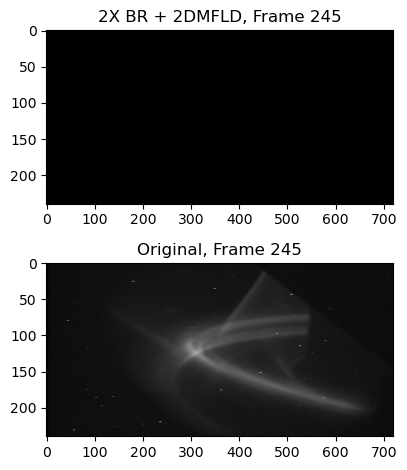

In [22]:
# single image plotting
idx = 245
kernel_size = 5
sigma = 1
threshold = 3
erode_kernel = 5
aspect_num = 1/2

# process = AdvancedProcessing()
# homofilt = HomomorphicFilter()

img = vid[idx]
img8 = (img/255).astype('uint8')
img8 = img8[0:240, 240:720]
probability = process_image(img)
# probability = homofilt.filter(img, (.9,50))

fig, ax = plt.subplots(2)
ax[0].imshow(probability, cmap='gray')
ax[1].imshow(img, cmap='gray')
x_left, x_right = ax[0].get_xlim()
y_low, y_high = ax[0].get_ylim()
ax[0].set_aspect(abs((x_right-x_left)/(y_low-y_high))*aspect_num)
ax[1].set_aspect(abs((x_right-x_left)/(y_low-y_high))*aspect_num)
ax[0].set_title(f'2X BR + 2DMFLD, Frame {idx}')
ax[1].set_title(f'Original, Frame {idx}')
plt.tight_layout()
plt.show()

In [28]:
result = hough_ellipse(edges, accuracy=20, threshold=250,
                       min_size=100, max_size=120)
result.sort(order='accumulator')

NameError: name 'edges' is not defined

In [ ]:
# animated plotting
savepath = Path('process_videos') / f'{filename}_inversion.mp4'

kernel_size = 5
sigma = 1
threshold = 4
erode_kernel = 4
aspect_num = 1/2

fig, ax = plt.subplots(2)
top = ax[0].imshow(probability, cmap='gray')
bot = ax[1].imshow(img8, cmap='gray')
title1 = ax[0].set_title(f'2X BR + 2DMFLD, Frame {0}')
title2 = ax[1].set_title(f'Original, Frame {0}')

x_left, x_right = ax[0].get_xlim()
y_low, y_high = ax[0].get_ylim()
ax[0].set_aspect(abs((x_right-x_left)/(y_low-y_high))*aspect_num)
ax[1].set_aspect(abs((x_right-x_left)/(y_low-y_high))*aspect_num)

plt.tight_layout()

def animate(i):
    img = np.sqrt(vid[i]).copy() # [25:250,250:700]
    ratio = np.amax(img) / 255
    img8 = (img/ratio).astype('uint8')
    img8 = img8[0:240, 240:720]
    probability = process_image(img8, kernel_size, sigma, threshold, erode_kernel)
    top.set_array(probability)
    bot.set_array(img8)
    title1.set_text(f'2X BR + 2DMFLD, Frame {i}')
    title2.set_text(f'Original, Frame {i}')
    return top, bot, title1, title2
    
writervideo = animation.FFMpegWriter(fps=30) 
ani = animation.FuncAnimation(fig, animate, frames=tqdm(range(len(vid))), blit=True)
ani.save(savepath, writer=writervideo)
plt.close()